## Predicting numeric values regression

- Pros: Easy to interpret results, computationally inexpensive
- Cons: Poorly models nonlinear data
- Works with: Numeric values, nominal values

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Implement Linear Regression

Linear Regression: $\theta=(X^TX)^{-1}X^Ty$

In [2]:
# Standard regression function and data-importing functions
def standRegres(xArr, yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xTx = xMat.T * xMat
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * yMat)
    return ws

Locally Weighted Linear Regression: $\theta=(X^TWX)^{-1}X^TWy$

In [3]:
# Locally weighted linear regression function
def lwlr(testPoint, xArr, yArr, k=1.0):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    m = np.shape(xMat)[0]
    # Create diagonal matrix
    weights = np.mat(np.eye((m)))
    for j in range(m):
        diffMat = testPoint - xMat[j, :]
        # Populate weights with exponentially decaying values
        weights[j, j] = np.exp(diffMat * diffMat.T / (-2.0 * k ** 2))
    xTx = xMat.T * (weights * xMat)
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * (weights * yMat))
    return testPoint * ws


def lwlrTest(testArr, xArr, yArr, k=1.0):
    m = np.shape(testArr)[0]
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i], xArr, yArr, k)
    return yHat

In [4]:
def rssError(yArr, yHatArr):
    return ((yArr - yHatArr) ** 2).sum()

Ridge Regression: $\theta=(X^TX+\lambda I)^{-1}X^Ty$

In [5]:
# Ridge regression
def ridgeRegres(xMat, yMat, lam=0.2):
    xTx = xMat.T * xMat
    denom = xTx + np.eye(np.shape(xMat)[1]) * lam
    if np.linalg.det(denom) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = denom.I * (xMat.T * yMat)
    return ws


def ridgeTest(xArr, yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    # Normalization code
    yMean = np.mean(yMat, 0)
    yMat = yMat - yMean
    xMeans = np.mean(xMat, 0)
    xVar = np.var(xMat, 0)
    xMat = (xMat - xMeans) / xVar
    numTestPts = 30
    wMat = np.zeros((numTestPts, np.shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat, yMat, np.exp(i - 10))
        wMat[i, :] = ws.T
    return wMat

In [6]:
# Forward stagewise linear regression
# Regularize the data to have 0 mean and unit variance
# For every iteration:
#     Set lowestError to + Inf
#     For every feature:
#         For increasing and decreasing:
#             Change one coefficient to get a new W
#             Calculate the Error with new W
#             If the Error is lower than lowestError:
#               set Wbest to the current W
#     Update set W to Wbest
def regularize(xMat):
    inMat = xMat.copy()
    inMeans = np.mean(inMat, 0)
    inVar = np.var(inMat, 0)
    inMat = (inMat - inMeans) / inVar
    return inMat


def stageWise(xArr, yArr, eps=0.01, numIt=100):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    yMean = np.mean(yMat, 0)
    yMat = yMat - yMean
    xMat = regularize(xMat)
    m, n = np.shape(xMat)
    returnMat = np.zeros((numIt, n))
    ws = np.zeros((n, 1))
    wsTest = ws.copy()
    wsMax = ws.copy()
    for i in range(numIt):
        lowestError = np.inf
        for j in range(n):
            for sign in [-1, 1]:
                wsTest = ws.copy()
                wsTest[j] += eps * sign
                yTest = xMat * wsTest
                rssE = rssError(yMat.A, yTest.A)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i, :] = ws.T
    return returnMat

### Experiment 1: Toy dataset

In [7]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t')) - 1
    dataMat, labelMat = [], []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [8]:
# Linear Regression

In [9]:
xArr, yArr = loadDataSet('ex0.txt')

In [10]:
ws = standRegres(xArr, yArr)
print(ws)

[[3.00774324]
 [1.69532264]]


In [11]:
xMat = np.mat(xArr)
yMat = np.mat(yArr)
yHat = xMat * ws
print(yHat[:5])

[[3.12257084]
 [3.73301922]
 [4.69582855]
 [4.25946098]
 [4.67099547]]


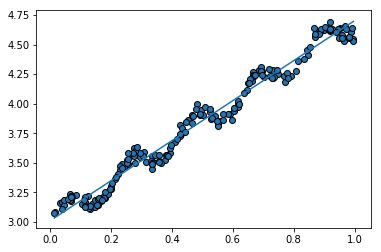

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:, 1].flatten().A[0], yMat.T[:, 0].flatten().A[0],
           edgecolors="black")
xCopy = xMat.copy()
xCopy.sort(0)
yHat = xCopy * ws
ax.plot(xCopy[:, 1], yHat)
plt.show()

In [13]:
yHat = xMat * ws
np.corrcoef(yHat.T, yMat)

array([[1.        , 0.98647356],
       [0.98647356, 1.        ]])

In [14]:
# Locally Weighted Linear Regression

In [15]:
xArr, yArr = loadDataSet('ex0.txt')

In [16]:
lwlr(xArr[0], xArr, yArr, 1.0)

matrix([[3.12204471]])

In [17]:
lwlr(xArr[0], xArr, yArr, 0.001)

matrix([[3.20175729]])

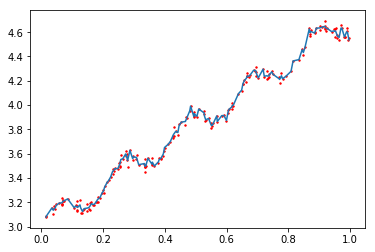

In [18]:
yHat = lwlrTest(xArr, xArr, yArr, 0.003)
xMat = np.mat(xArr)
srtInd = xMat[:, 1].argsort(axis=0)
xSort = xMat[srtInd][:, 0, :]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xSort[:, 1], yHat[srtInd])
ax.scatter(xMat[:, 1].flatten().A[0], yArr, s=2, c='red')
plt.show()

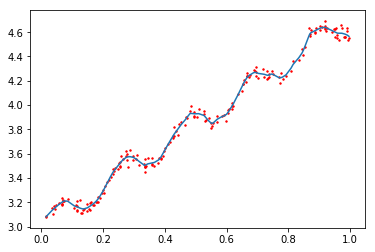

In [19]:
yHat = lwlrTest(xArr, xArr, yArr, 0.01)
xMat = np.mat(xArr)
srtInd = xMat[:, 1].argsort(axis=0)
xSort = xMat[srtInd][:, 0, :]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xSort[:, 1], yHat[srtInd])
ax.scatter(xMat[:, 1].flatten().A[0], yArr, s=2, c='red')
plt.show()

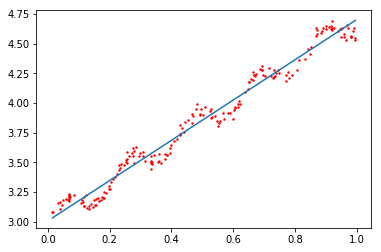

In [20]:
yHat = lwlrTest(xArr, xArr, yArr, 1)
xMat = np.mat(xArr)
srtInd = xMat[:, 1].argsort(axis=0)
xSort = xMat[srtInd][:, 0, :]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xSort[:, 1], yHat[srtInd])
ax.scatter(xMat[:, 1].flatten().A[0], yArr, s=2, c='red')
plt.show()

### Experiment 2: Abalone dataset

In [21]:
abX, abY = loadDataSet('abalone.txt')

In [22]:
# Locally Weighted Linear Regression

In [23]:
yHat01 = lwlrTest(abX[0: 99], abX[0: 99], abY[0: 99], 0.1)
yHat1 = lwlrTest(abX[0: 99], abX[0: 99], abY[0: 99], 1)
yHat10 = lwlrTest(abX[0: 99], abX[0: 99], abY[0: 99], 10)
print(rssError(abY[0: 99], yHat01))
print(rssError(abY[0: 99], yHat1))
print(rssError(abY[0: 99], yHat10))

56.78868743050092
429.89056187038
549.1181708827924


In [24]:
yHat01 = lwlrTest(abX[100: 199], abX[0: 99], abY[0: 99], 0.1)
yHat1 = lwlrTest(abX[100: 199], abX[0: 99], abY[0: 99], 1)
yHat10 = lwlrTest(abX[100: 199], abX[0: 99], abY[0: 99], 10)
print(rssError(abY[100: 199], yHat01))
print(rssError(abY[100: 199], yHat1))
print(rssError(abY[100: 199], yHat10))

57913.51550155911
573.5261441895982
517.5711905381903


In [25]:
# Linear Regression

In [26]:
ws = standRegres(abX[0: 99], abY[0: 99])
yHat = np.mat(abX[100: 199]) * ws
print(rssError(abY[100:199], yHat.T.A))

518.6363153245542


In [27]:
# Ridge Regression

In [28]:
abX, abY = loadDataSet('abalone.txt')

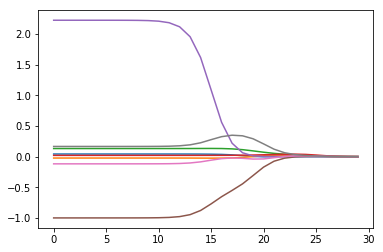

In [29]:
ridgeWeights = ridgeTest(abX, abY)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)
plt.show()

In [30]:
# Forward Stagewise Linear Regression

In [31]:
xArr, yArr = loadDataSet('abalone.txt')

In [32]:
stageWise(xArr, yArr, 0.01, 200)

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.04,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36]])

In [33]:
stageWise(xArr, yArr, 0.001, 5000)

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.044, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187]])

In [34]:
xMat = np.mat(xArr)
yMat = np.mat(yArr).T
xMat = regularize(xMat)
yM = np.mean(yMat, 0)
yMat = yMat - yM
weights = standRegres(xMat, yMat.T)
weights.T

matrix([[ 0.0430442 , -0.02274163,  0.13214087,  0.02075182,  2.22403814,
         -0.99895312, -0.11725427,  0.16622915]])

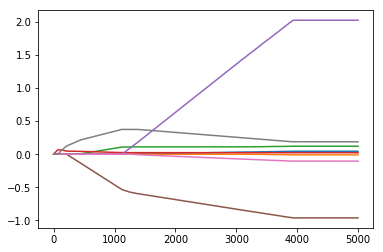

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(stageWise(xArr, yArr, 0.001, 5000))
plt.show()

### Experiment 3: LEGO set dataset

In [36]:
# Shopping information retrieval function
# Load from local cache, unable to retrieve NewOrUsed feature
def searchForSet(retX, retY, setNum, yr, numPce, origPrc):
    file_name = "setHtml/lego" + str(setNum) + ".html"
    input_file = open(file_name, encoding="utf8")
    page = input_file.read()
    input_file.close()
    pattern = re.compile(r'\$([\d,]+\.\d+)')
    result = pattern.findall(page)
    for price in result:
        price = price.replace(",", "")
        # Filter out fractional sets
        if float(price) <= origPrc * 0.5:
            continue
        retX.append([yr, numPce, origPrc])
        retY.append(float(price))


def setDataCollect(retX, retY):
    searchForSet(retX, retY, 8288, 2006, 800, 49.99)
    searchForSet(retX, retY, 10030, 2002, 3096, 269.99)
    searchForSet(retX, retY, 10179, 2007, 5195, 499.99)
    searchForSet(retX, retY, 10181, 2007, 3428, 199.99)
    searchForSet(retX, retY, 10189, 2008, 5922, 299.99)
    searchForSet(retX, retY, 10196, 2009, 3263, 249.99)

In [37]:
lgX, lgY = [], []
setDataCollect(lgX, lgY)

In [38]:
lgX1 = np.mat(np.ones((82, 4)))
lgX1[:, 1: 4] = np.mat(lgX)
ws = standRegres(lgX1, lgY)
print(ws)

[[ 5.09659003e+04]
 [-2.54263162e+01]
 [-2.92992001e-02]
 [ 2.66427939e+00]]


In [39]:
# Cross-validation testing with ridge regression
def crossValidation(xArr, yArr, numVal=10):
    m = len(yArr)
    indexList = list(range(m))
    errorMat = np.zeros((numVal, 30))
    for i in range(numVal):
        # Create training and test containers
        trainX, trainY = [], []
        testX, testY = [], []
        np.random.shuffle(indexList)
        for j in range(m):
            # Split data into test and training sets
            if j < m * 0.9:
                trainX.append(xArr[indexList[j]])
                trainY.append(yArr[indexList[j]])
            else:
                testX.append(xArr[indexList[j]])
                testY.append(yArr[indexList[j]])
        wMat = ridgeTest(trainX, trainY)
        for k in range(30):
            # Regularize test with training params
            matTrainX = np.mat(trainX)
            matTestX = np.mat(testX)
            meanTrain = np.mean(matTrainX, 0)
            varTrain = np.var(matTrainX, 0)
            matTestX = (matTestX - meanTrain) / varTrain
            yEst = matTestX * np.mat(wMat[k, :]).T + np.mean(trainY)
            errorMat[i, k] = rssError(yEst.T.A, np.array(testY))
    meanErrors = np.mean(errorMat, 0)
    minMean = float(min(meanErrors))
    bestWeights = wMat[np.nonzero(meanErrors == minMean)]
    # Undo regularization
    # can unregularize to get model
    # when we regularized we wrote Xreg = (x - meanX) / var(x)
    # we can now write in terms of x not Xreg:
    # x * w / var(x) - meanX / var(x) + meanY
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    meanX = np.mean(xMat, 0)
    varX = np.var(xMat, 0)
    unReg = bestWeights / varX
    print("the best model from Ridge Regression is:\n", unReg)
    print("with constant term: ",
          -1 * np.sum(np.multiply(meanX, unReg)) + np.mean(yMat))

In [40]:
crossValidation(lgX, lgY, 10)

the best model from Ridge Regression is:
 [[-2.47902660e+01 -7.79292640e-05  2.16690626e+00]]
with constant term:  49726.10765364624
